### functions and derivatives 

#### simple

In [1]:
from graphviz import Digraph
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# 先简单知道函数，以及函数的导数是怎么回事，可以很直观的感受到，
def f(x):
    return 3*x**2 - 4*x + 5

In [9]:
f(3.0)

20.0

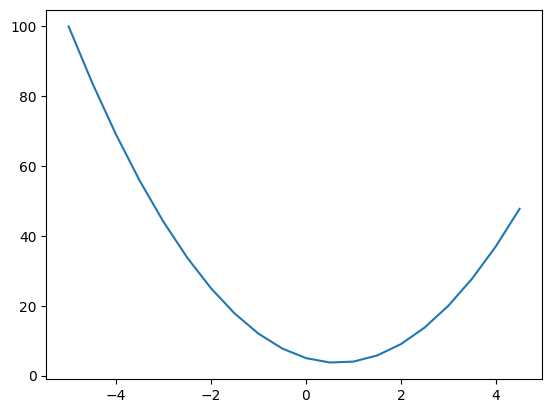

In [12]:
xs = np.arange(-5, 5, 0.5)
ys = f(xs)
plt.plot(xs, ys)

In [16]:
h = 0.00001
x = 3.0
(f(x+h)-f(x)) / h

14.00003000000538

#### sophiscated

In [17]:
# 复杂一点的函数，偏导数的概念
a = 2.0
b = 3.0
c = 10.0
d = a*b + c
print(d)

16.0


In [22]:
h = 0.0001
a = 2.0
b = 3.0
c = 10.0
d1 = a*b + c
c += h
d2 = a*b + c
print((d2-d1)/h)

0.9999999999976694


### Value

#### value class

In [80]:
# 然后用Value 可以表达简答的数学运算，并且看看怎么用这个东西来表达梯度，其实这个词本身也挺难的，本质上其实就是函数的求导
# 先手动计算一下各自的 gradient 
# 然后看看怎么自动计算

In [225]:
class Value:
    def __init__(self, v, child=(), _op="", _label=""):
        for c in child:
            if type(c) != Value:
                print("found!",c, _op)
        self.grad = 0.0
        self.data = v
        self._prev = child
        self._op = _op
        self._label = _label
        self._backward = lambda: None

    def __add__(self, other):
        
        if type(other) != Value:
            other = Value(other)
        v = Value(self.data + other.data)
        v._op = '+'
        v._prev = (self, other)
        
        def _backward():
            self.grad += v.grad
            other.grad += v.grad
        
        v._backward = _backward
        return v

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        if type(other) != Value:
            other = Value(other)
        v = Value(self.data - other.data, child=(self, other), _op="-",)
        
        def _backward():
            self.grad += v.grad
            other.grad += -v.grad
        v._backward = _backward
        
        return v
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, child=(self, ), _op="tanh")
        
        def _backward():
            self.grad += (1-t**2) * out.grad
            
        out._backward = _backward        
        
        return out
    
    def sin(self):
        out = Value(math.sin(self.data), child=(self, ), _op="sin")
        
        def _backward():
            self.grad += math.cos(self.data) * out.grad
            
        out._backward = _backward        
        
        return out

    def exp(self):
        t = math.exp(self.data)
        out = Value(t, child=(self, ), _op="exp")
        
        def _backward():
            self.grad += t * out.grad
            
        out._backward = _backward        
        
        return out

    def log(self):
        t = math.log(self.data)
        out = Value(t, child=(self, ), _op="log")
        
        def _backward():
            self.grad += (1/self.data) * out.grad
            
        out._backward = _backward        
        
        return out
    
    def __pow__(self, other):
        if type(other) != Value:
            other = Value(other)
        out = Value(
            self.data ** other.data,
            child=(self, other),
            _op="pow",
        )
        
        def _backward():
            self.grad += other.data * self.data**(other.data-1) * out.grad
            
        out._backward = _backward        
        
        return out
    def __neg__(self):
        out = Value(
            -self.data,
            child=(self, ),
            _op="-",
        )
        
        def _backward():
            self.grad += -1 * out.grad
            
        out._backward = _backward
        return out
        
    def __truediv__(self, other):
        if type(other) != Value:
            other = Value(other)
            
        out = Value(
            self.data / other.data,
            child=(self, other),
            _op="/",
        )
        
        def _backward():
            self.grad += (1.0/other.data) * out.grad
            other.grad += -self.data * other.data**(-2) * out.grad
            
        out._backward = _backward        
        
        return out
    def __rtruediv__(self, other):
        other = Value(other)
        return other / self
    
    def __mul__(self, other):
        
        if type(other) != Value:
            other = Value(other)
        
            
        v = Value(self.data * other.data)
        v._op = '*'
        v._prev = (self, other)
        
        def _backward():
            self.grad += other.data * v.grad
            other.grad += self.data * v.grad
            
        v._backward = _backward
            
        return v
    
    def __rmul__(self, other):
        return self * other
    
    def zero_grad(self):
        self.grad = 0.0
        for t in self._prev:
            t.zero_grad()
    
    def backward(self):
        self.grad = 1.0
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for c in v._prev:
                    build_topo(c)
                topo.append(v)
        build_topo(self)
        for t in reversed(topo):
            t._backward()

    def __repr__(self):
        return f"Value(data={self.data}, op={self._op})"

In [17]:
# test
a = Value(2.0, _label='a')
b = Value(-3.0, _label='b')
c = Value(10.0, _label='c')

a-3




Value(data=-1.0, op=-)

In [ ]:
f = a + b*c
df/da 
df/dc = df/de * de/dc
df/db = df/de * de/db

e=b*c
de/db
de/dc

f = a + e


#### VALUE TEST

In [65]:
a = Value(2.0, _label='a')
b = Value(-3.0, _label='b')
c = Value(10.0, _label='c')
e = a*b; e._label='e'
d = e + c
d._label='d'
f = Value(-2.0, _label='f')
L = f * d; L._label='L'

In [75]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0

In [72]:
def lol():
    h = 0.0001
    a = Value(2.0, _label='a')
    b = Value(-3.0, _label='b')
    c = Value(10.0, _label='c')
    e = a*b; e._label='e'
    d = e + c
    d._label='d'
    f = Value(-2.0, _label='f')
    L = f * d; L._label='L'
    l1 = L.data
    
    a = Value(2.0, _label='a')
    b = Value(-3.0, _label='b')
    c = Value(10.0, _label='c')
    e = a*b; e._label='e'
    d = e + c
    d._label='d'
    f = Value(-2.0, _label='f')
    L = f * d; L._label='L'
    l2 = L.data + h
    
    print((l2-l1)/h)
    
lol()

0.9999999999976694


In [67]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s|  %.4f | grad %.4f }" % (n._label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

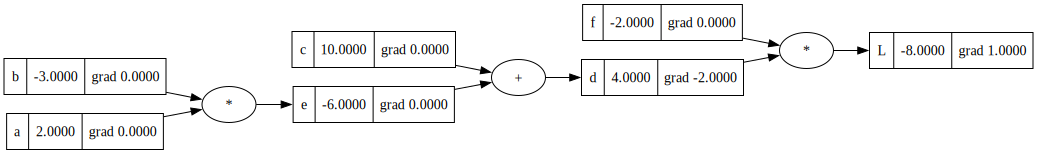

In [74]:
draw_dot(L)

#### simplest nn

In [76]:
# 手动把这些 gradient 算出来之后，有什么用呢？我可以让这些变量沿着 gradient 的方向，就可以让最终的结果变大

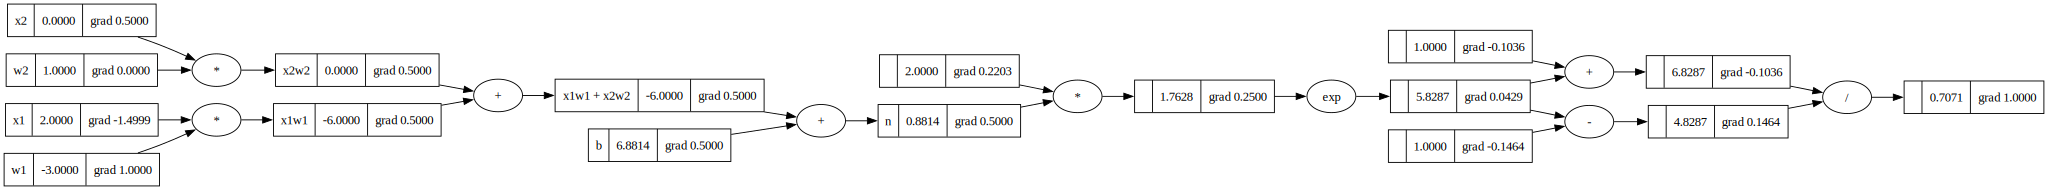

In [226]:
# 类似神经网络的一个玩意儿
# input
x1 = Value(2.0, _label="x1")
x2 = Value(0.0, _label="x2")

w1 = Value(-3.0, _label="w1")
w2 = Value(1.0, _label="w2")

b = Value(6.8814, _label="b")

x1w1 = x1*w1; x1w1._label="x1w1"
x2w2 = x2*w2; x2w2._label="x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label="x1w1 + x2w2"
n = x1w1x2w2 + b; n._label="n"

e = (2*n).exp()
# o = n.tanh(); o._label='o'
o = (e - 1) / (e + 1)
o.backward()
draw_dot(o)

In [120]:
o.backward()

In [116]:
for t in reversed(topo):
    t._backward()

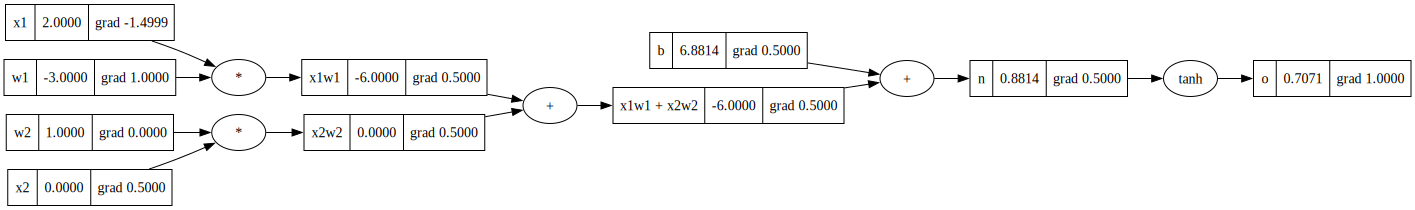

In [121]:
draw_dot(o)

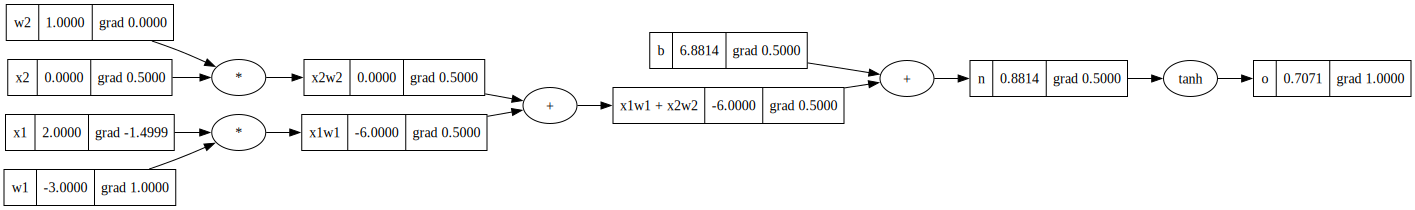

In [117]:

draw_dot(o)

#### homework

In [174]:
# here is a mathematical expression that takes 3 inputs and produces one output
from math import sin, cos

def f(a, b, c):
  return -a**3 + sin(3*b) - 1.0/c + b**2.5 - a**0.5

print(f(2, 3, 4))

6.336362190988558


In [173]:
# write the function df that returns the analytical gradient of f
# i.e. use your skills from calculus to take the derivative, then implement the formula
# if you do not calculus then feel free to ask wolframalpha, e.g.:
# https://www.wolframalpha.com/input?i=d%2Fda%28sin%283*a%29%29%29

def gradf(a, b, c):
    av = Value(a)
    bv = Value(b)
    cv = Value(c)
    
    out = -1*av**3 + (3*bv).sin() - 1.0/cv + bv**2.5 - av**0.5
    out.backward()
    
    return [av.grad, bv.grad, cv.grad] # todo, return [df/da, df/db, df/dc]

# expected answer is the list of 
ans = [-12.353553390593273, 10.25699027111255, 0.0625]
yours = gradf(2, 3, 4)
for dim in range(3):
  ok = 'OK' if abs(yours[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {yours[dim]}")


OK for dim 0: expected -12.353553390593273, yours returns -12.353553390593273
OK for dim 1: expected 10.25699027111255, yours returns 10.25699027111255
OK for dim 2: expected 0.0625, yours returns 0.0625


In [186]:
# now estimate the gradient numerically without any calculus, using
# the approximation we used in the video.
# you should not call the function df from the last cell

# -----------
numerical_grad = [0, 0, 0] # TODO
# -----------

h = 0.0000001
v1 = f(2, 3, 4)
for i in range(3):
    hs = [2, 3, 4]
    hs[i] += h
    v2 = f(*hs)
    numerical_grad[i] = (v2-v1)/h

for dim in range(3):
  ok = 'OK' if abs(numerical_grad[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {numerical_grad[dim]}")


OK for dim 0: expected -12.353553390593273, yours returns -12.353553966448771
OK for dim 1: expected 10.25699027111255, yours returns 10.256990385926201
OK for dim 2: expected 0.0625, yours returns 0.06249999628948899


In [192]:
# there is an alternative formula that provides a much better numerical 
# approximation to the derivative of a function.
# learn about it here: https://en.wikipedia.org/wiki/Symmetric_derivative
# implement it. confirm that for the same step size h this version gives a
# better approximation.

# -----------
numerical_grad2 = [0, 0, 0] # TODO
# -----------


h = 0.0000001
for i in range(3):
    hs1 = [2, 3, 4]
    hs2 = [2, 3, 4]
    
    hs1[i] -= h
    hs2[i] += h
    
    v1 = f(*hs1)
    v2 = f(*hs2)
    numerical_grad2[i] = (v2-v1)/(2*h)
    
    
for dim in range(3):
  ok = 'OK' if abs(numerical_grad2[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  diff1 = abs(ans[dim] - numerical_grad2[dim])
  diff2 = abs(ans[dim] - numerical_grad[dim])
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {numerical_grad2[dim]}, diff {diff2 / diff1}")
    


OK for dim 0: expected -12.353553390593273, yours returns -12.353553380251014, diff 55.679858760662256
OK for dim 1: expected 10.25699027111255, yours returns 10.256990252699438, diff 6.235429292490782
OK for dim 2: expected 0.0625, yours returns 0.06250000073038109, diff 5.0802397073702235


In [223]:
# without referencing our code/video __too__ much, make this cell work
# you'll have to implement (in some cases re-implemented) a number of functions
# of the Value object, similar to what we've seen in the video.
# instead of the squared error loss this implements the negative log likelihood
# loss, which is very often used in classification.

# this is the softmax function
# https://en.wikipedia.org/wiki/Softmax_function
def softmax(logits):
  counts = [logit.exp() for logit in logits]
  denominator = sum(counts)
  out = [c / denominator for c in counts]
  return out

# this is the negative log likelihood loss function, pervasive in classification
logits = [Value(0.0), Value(3.0), Value(-2.0), Value(1.0)]
probs = softmax(logits)
loss = -probs[3].log() # dim 3 acts as the label for this input example

loss.backward()

ans = [0.041772570515350445, 0.8390245074625319, 0.005653302662216329, -0.8864503806400986]
for dim in range(4):
  ok = 'OK' if abs(logits[dim].grad - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {logits[dim].grad}")


OK for dim 0: expected 0.041772570515350445, yours returns 0.041772570515350445
OK for dim 1: expected 0.8390245074625319, yours returns 0.8390245074625319
OK for dim 2: expected 0.005653302662216329, yours returns 0.005653302662216329
OK for dim 3: expected -0.8864503806400986, yours returns -0.886450380640099


#### pytorch

In [237]:
# verify the gradient using the torch library
# torch should give you the exact same gradient
import torch

import importlib
importlib.reload(torch)


out = torch.Tensor([]).double();out.requires_grad = True
# out.Softmax()


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/yl/miniconda3/envs/reflexion/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/yl/miniconda3/envs/reflexion/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/yl/miniconda3/envs/reflexion/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    s

In [262]:

out = torch.Tensor([0.0, 3.0, -2.0, 1.0]);out.requires_grad = True
m=torch.nn.Softmax(dim=0)
print(m(out)[0].item())

0.041772566735744476


In [231]:
input = torch.randn(2, 3)

AttributeError: module 'torch' has no attribute 'randn'

In [229]:
torch.__version__

AttributeError: module 'torch' has no attribute '__version__'

In [255]:
m = torch.nn.Softmax(dim=-1)
input = torch.randn(2,3)
output = m(input)

tensor(1.)

In [244]:
output

tensor([[0.7948, 0.1204, 0.0848],
        [0.0338, 0.0901, 0.8761]])

In [263]:
# implement your own nn

### Neuron Network

In [185]:
np.random.uniform(0, 5)

0.2973684145781408

In [186]:
np.random.randn(0, 1)

array([], shape=(0, 1), dtype=float64)

In [179]:
class Neuron:
    def __init__(self, n):
        # self.bias = Value(np.random.uniform(-1, 1))
        self.bias = Value(np.random.randn(0, 1))
        self.weights = [Value(np.random.uniform(-1, 1)) for i in range(n)]
        
    def params(self):
        return self.weights + [self.bias]

    def __call__(self, values):
        act = sum([w*v for (w, v) in zip(self.weights, values)], self.bias)
        # return act.tanh()
        return act

        

class Layer:
    def __init__(self, n, pn):
        self.neurons = [Neuron(pn) for _ in range(n)]
        
    def params(self):
        return [p for n in self.neurons for p in n.params()]

    def __call__(self, values):
        ans = []
        for n in self.neurons:
            ans.append(n(values))
        return ans

    def backward(self):
        for n in self.neurons:
            n.backward()
        
        

class MLP:
    def __init__(self, shape):
        assert(len(shape)>=1)

        self.layers = []
        pn = shape[0]
        for n in shape[1:]:
            self.layers.append(
                Layer(n, pn),
            )
            pn = n
            
    def __call__(self, inputs):
        n = len(inputs)
        assert(n == len(self.layers[0].neurons[0].weights))
        values = [Value(data) for data in inputs]
        for l in self.layers:
            values = l(values)
        return values

    def backward(self, outs, expected):
        diffs = [((y2-y1)**2)/2 for y1, y2 in zip(expected, outs)]
        out = sum(diffs) / len(diffs)
        out.grad = 1.0
        out.backward()
        return out

    # add batch_size
    def train(self, val, test=None, n=10, lr=0.01, batch_size=10):
        for i in range(n):
            expects = [n for p in val for n in p[1]]
            outs = [n for p in val for n in self(p[0])]
            self.zero_grad()
            self.backward(outs, expects)
            self.update(lr)
        
    def params(self):
        return [p for layer in self.layers for p in layer.params()]

    def zero_grad(self):
        for p in self.params():
            p.grad = 0.0
                
    def update(self, lr=0.01):
        for p in self.params():
            p.data -= lr*p.grad
                



In [177]:
nn = MLP([2, 3, 1])
data = [
    [(1,2), (3, )],
    [(2,4), (9, )],
    [(5,9), (46, )],
]
nn.train(data, n=1000, lr=0.05)
# nn.forward('input')
# s = nn([1,2])

360.0732574812536
348.8611018036184
348.86049537911373
348.85991499008804
348.85935899031216
348.85882586977294
348.8583142408463
348.8578228261243
348.8573504476679
348.85689601749476
348.85645852913984
348.8560370501502
348.8556307153938
348.8552387210835
348.8548603194262
348.85449481382415
348.85414155456107
348.8537999349184
348.8534693876713
348.85314938192255
348.8528394202361
348.85253903603893
348.8522477912604
348.8519652741865
348.85169109750376
348.8514248965168
348.8511663275181
348.85091506629914
348.85067080678385
348.85043325977813
348.85020215182016
348.8499772241236
348.84975823160516
348.84954494198877
348.84933713497827
348.8491346014949
348.8489371429709
348.8487445706966
348.8485567052159
348.8483733757652
348.8481944197526
348.8480196822746
348.8478490156667
348.8476822790849
348.84751933811566
348.8473600644132
348.8472043353607
348.8470520337532
348.84690304750256
348.846757269361
348.8466145966622
348.84647493107906
348.8463381783966
348.8462042482992
348.8460

In [166]:
oo = nn((9,2))
oo

[Value(data=0.26867417754789746, op=tanh)]

In [110]:
nn.params()

[Value(data=0.044842540469588354, op=),
 Value(data=0.3071099011566726, op=),
 Value(data=0.6344170856840657, op=),
 Value(data=0.480301392698836, op=),
 Value(data=0.15104246594225723, op=),
 Value(data=0.2256994841802853, op=),
 Value(data=0.6865388951954206, op=),
 Value(data=0.36477484238542845, op=),
 Value(data=0.24483501317977285, op=),
 Value(data=0.7841612892450703, op=),
 Value(data=0.6232820878390624, op=),
 Value(data=0.975081276903968, op=),
 Value(data=0.6926778143660299, op=)]

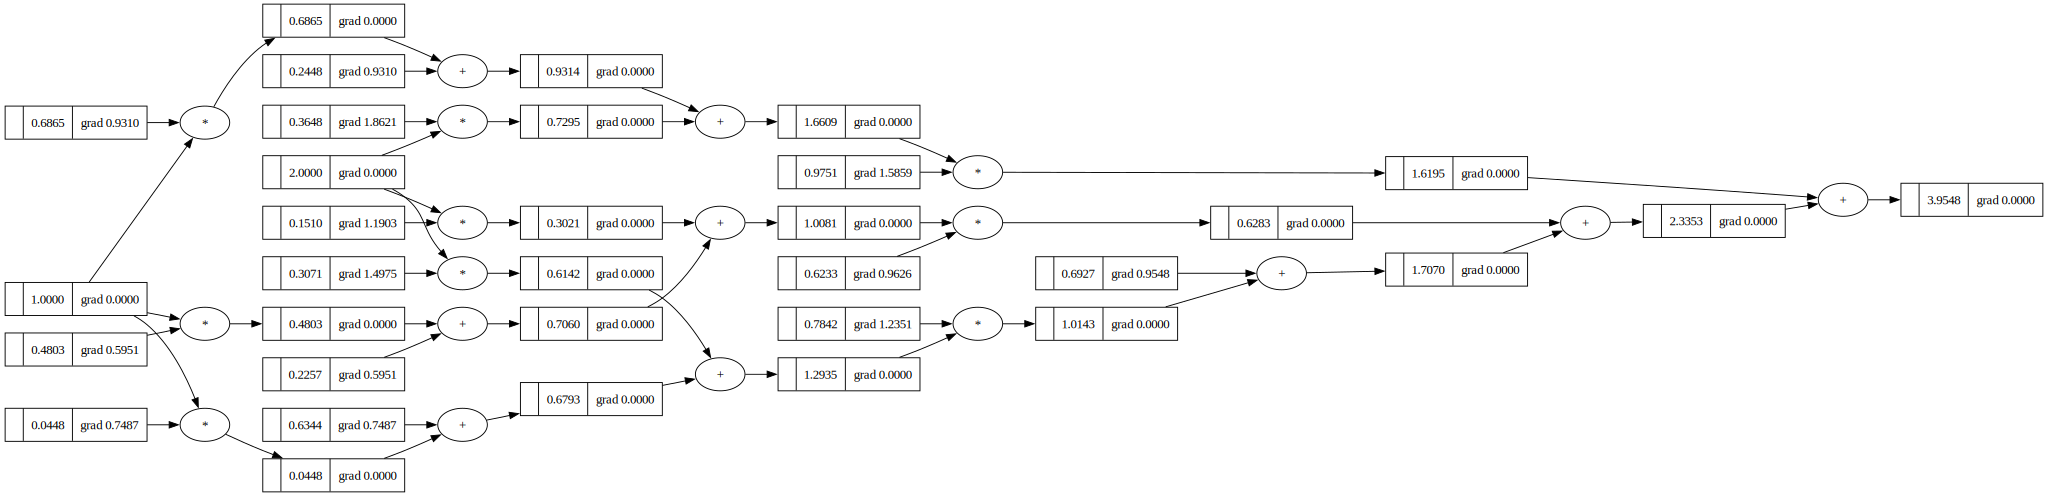

In [112]:
draw_dot(oo[0])